In [1]:
import time
import skfda 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import block_diag
from scipy.stats import rankdata
from skfda.representation.basis import FourierBasis
from skfda.preprocessing.smoothing import BasisSmoother
from concurrent.futures import ThreadPoolExecutor

# Needed functions

Zhang et al. introduced an intriguing concept for testing the independence of multivariate data. In this study, we aim to apply their approach to assess the independence of functional data. The following code implements the key functions proposed by Zhang et al.

Zhang, W., Gao, W., & Ng, H. K. T. (2023). Multivariate tests of independence based on a new class of measures of independence in Reproducing Kernel Hilbert Space. Journal of Multivariate Analysis, 195, 105144.

In [3]:
# Pytorch version

n = 100
HH = np.eye(n) - np.outer(np.ones(n), np.ones(n)) / n
HH = torch.tensor(HH)

def L_n(x, C_dim = 1):
    x = torch.tensor(x)
    odl = torch.cdist(x, x, p=2)
    mask = ~torch.triu(torch.ones(odl.size()), diagonal=0).bool()
    vector = torch.masked_select(odl, mask)
    sigma = torch.median(odl)
    
    l_return = torch.zeros((x.shape[0], x.shape[0]))
    const_1 = 2 * (sigma**2) / (1 + sigma**2)
    const_2 = 2 * (sigma**4) / (1 + sigma**2) + 2 * const_1
    
    norm_2 = odl**2
    il_sk = torch.matmul(x, x.T)
    
    l_return = torch.exp(-(norm_2 + const_1 * il_sk) / const_2)
    
    return l_return

def L_t(x, ksi=1, C_dim = 1e-90):
    x = torch.tensor(x)
    #C_dim = 1 / x.shape[1]
    #C_dim = 1e-130
    #C_dim = 1e-90
    odl = torch.cdist(x, x)
    mask = ~torch.triu(torch.ones(odl.size()), diagonal=0).bool()
    vector = torch.masked_select(odl, mask)
    sigma = torch.median(vector)
    BB = 8 * ksi - 2 * (ksi + 1) * sigma**2
    norm_2 = odl**2
    CC = torch.exp(-norm_2 / (4 * sigma**2))
    L_t1 = 1
    
    for j in range(x.shape[1]):
        Z = x[:, j]
        outer = BB - (ksi + 1) * (Z.view(-1, 1) + Z.view(1, -1))**2
        L_t1 = L_t1 * outer
    
    return C_dim * CC * L_t1

def NDIME(X, Y, HH = HH, C_dim = 1):
    return torch.sum(torch.diag(torch.matmul(torch.matmul(torch.matmul(L_n(X, C_dim = C_dim), HH), L_n(Y, C_dim = C_dim)), HH))) / X.shape[0]**2

def tDIME(X, Y, HH = HH, C_dim = 1):
    return torch.sum(torch.diag(torch.matmul(torch.matmul(torch.matmul(L_t(X, C_dim = C_dim), HH), L_t(Y, C_dim = C_dim)), HH))) / X.shape[0]**2

def perm_test(X, Y, func, B=1000, C_dim = 1):
    n = X.shape[0]
    test_statistic = func(X, Y, HH, C_dim)
    
    results = torch.tensor([])
    for i in range(B):
        Y_perm = Y[np.random.permutation(n), :]
        results = torch.cat((results, torch.tensor([func(X, Y_perm, HH, C_dim)])),dim=0)
    
    p_value = torch.mean((results > test_statistic).to(torch.float))
    
    return p_value

def perm_test2(X, Y, func, B=1000, C_dim = 1):
    n = X.shape[0]
    test_statistic = func(X, Y, HH, C_dim)
    
    results = torch.tensor([])
    for i in range(B):
        Y_perm = Y[np.random.permutation(n), :]
        results = torch.cat((results, torch.tensor([func(X, Y_perm, HH, C_dim)])),dim=0)
    
    p_value = torch.mean((results > test_statistic).to(torch.float))
    
    return {'p_value':p_value, 'results':results, 'test_statistic':test_statistic}
            

The following Python-functions samples coeficients of $a_0 + a_1sin(x) + a_2cos(x) + a_3sin(2x) + a_4cos(2x)$ from normal and t distribution.

In [4]:
def sampling_x_n():
    return np.concatenate([np.random.normal(1, 4, size=1), \
                           np.random.normal(1, 1, size=1), \
                           np.random.normal(1, 9, size=1), \
                           np.random.normal(1, 9, size=1), \
                           np.random.normal(1, 6, size=1)])

def sampling_y_n():
    return np.concatenate([np.random.normal(1, 4, size=1), \
                           np.random.normal(1, 2, size=1), \
                           np.random.normal(1, 0, size=1), \
                           np.random.normal(1, 2, size=1), \
                           np.random.normal(1, 3, size=1)])

def sampling_x_t():
    return np.concatenate([np.random.standard_t(5, size=1), \
                           np.random.standard_t(5, size=1), \
                           np.random.standard_t(5, size=1), \
                           np.random.standard_t(5, size=1), \
                           np.random.standard_t(5, size=1)])

def sampling_y_t():
    return np.concatenate([np.random.standard_t(6, size=1), \
                           np.random.standard_t(6, size=1), \
                           np.random.standard_t(6, size=1), \
                           np.random.standard_t(6, size=1), \
                           np.random.standard_t(6, size=1)])

The following Python-functions generate observations of $a_0 + a_1sin(x) + a_2cos(x) + a_3sin(2x) + a_4cos(2x)$ over the interval $[0, 2\pi]$.

In [5]:
def sample_X(n, sampling_x):
    X = np.zeros((n, 30))
    coef_X = np.zeros((n, 11))
    xh1 = np.sin(np.linspace(0, 2 * np.pi, num = 30))
    xh2 = np.cos(np.linspace(0, 2 * np.pi, num = 30))
    xh3 = np.sin(2 * np.linspace(0, 2 * np.pi, num = 30))
    xh4 = np.cos(2 * np.linspace(0, 2 * np.pi, num = 30))
    
    for i in range(n):
        coef_X[i,:] = np.concatenate([sampling_x(), np.zeros(11 - 5)])
        X[i,:] = coef_X[i, 0] + coef_X[i, 1] * xh1 + coef_X[i, 2] * xh2 + coef_X[i, 3] * xh3 + coef_X[i, 4] * xh4 
    
    return (X, coef_X)
        
def sample_Y(n, sampling_y):
    Y = np.zeros((n, 30))
    coef_Y = np.zeros((n, 11))
    xh1 = np.sin(np.linspace(0, 2 * np.pi, num = 30))
    xh2 = np.cos(np.linspace(0, 2 * np.pi, num = 30))
    xh3 = np.sin(2 * np.linspace(0, 2 * np.pi, num = 30))
    xh4 = np.cos(2 * np.linspace(0, 2 * np.pi, num = 30))
    
    for i in range(n):
        coef_Y[i,:] = np.concatenate([sampling_y(), np.zeros(11 - 5)])
        Y[i,:] = coef_Y[i, 0] + coef_Y[i, 1] * xh1 + coef_Y[i, 2] * xh2 + coef_Y[i, 3] * xh3 + coef_Y[i, 4] * xh4
        
    return (Y, coef_Y)

This Python-function smoothens the observations in matrix $Y$ and returns coefficients of finite fourier series.

In [6]:
def coef_Y_return(Y):
    fd = skfda.FDataGrid(data_matrix=Y, grid_points=np.linspace(0, 2 * np.pi, num = 30))
    basis = FourierBasis((0, 2 * np.pi), n_basis=11)
    smoother = skfda.preprocessing.smoothing.BasisSmoother(basis, return_basis=True)
    fd_smooth = smoother.fit_transform(fd)
    return fd_smooth.coefficients

This Python-function conducts a permutation test for two independent samples. It returns a Python-dictionary with boolean values indicating whether the p-value of Zhang's test is below 0.05.

In [7]:
def setting_independent_n(sampling_x, sampling_y, n = 100, C_dim_n = 1, C_dim_t = 1, C_dim_t2 = 1):
    X, coef_X = sample_X(n, sampling_x)
    
    Y, coef_Y = sample_Y(n, sampling_y)
    
    n_res1 = perm_test(X, Y, func = NDIME, C_dim = C_dim_n) < 0.05
    n_res2 = perm_test(coef_X, coef_Y, func = NDIME, C_dim = C_dim_n) < 0.05
    t_res1 = perm_test(X, Y, func = tDIME, C_dim = C_dim_t) < 0.05
    t_res2 = perm_test(coef_X, coef_Y, func = tDIME, C_dim = C_dim_t2) < 0.05

    return {'vec_n': n_res1, \
            'vec_t': t_res1, \
            'fda_n': n_res2, \
            'fda_t': t_res2}

This Python-function is analogous but operates on dependent data.

In [8]:
def setting_dependent_n(fun, sampling_x, n = 100, C_dim_n = 1, C_dim_t = 1, C_dim_t2 = 1):
    X, coef_X = sample_X(n, sampling_x)
    
    Y = fun(X)

    coef_Y = coef_Y_return(Y)
    
    n_res1 = perm_test(X, Y, func = NDIME, C_dim = C_dim_n) < 0.05
    n_res2 = perm_test(coef_X, coef_Y, func = NDIME, C_dim = C_dim_n) < 0.05
    t_res1 = perm_test(X, Y, func = tDIME, C_dim = C_dim_t) < 0.05
    t_res2 = perm_test(coef_X, coef_Y, func = tDIME, C_dim = C_dim_t2) < 0.05

    return {'vec_n': n_res1, \
            'vec_t': t_res1, \
            'fda_n': n_res2, \
            'fda_t': t_res2}

The last two Python-functions plot samples of independent and dependent data.

In [9]:
def plot_idenpendent(sampling_x, sampling_y):
    X, coef_X = sample_X(n, sampling_x)

    Y, coef_Y = sample_Y(n, sampling_y)

    fig, axs = plt.subplots(1, 2, figsize = (10,5))  

    axs[0].plot(X.T)
    axs[0].set_title('X')

    axs[1].plot(Y.T)
    axs[1].set_title('Y')

    plt.show()

In [10]:
def plot_dependent(sampling_x, func_y, y_title):
    X, coef_X = sample_X(n, sampling_x)

    Y = func_y(X)

    coef_Y = coef_Y_return(Y)

    fig, axs = plt.subplots(1, 2, figsize = (10,5))  

    axs[0].plot(X.T)
    axs[0].set_title('X')

    axs[1].plot(Y.T)
    axs[1].set_title(y_title)

    plt.show()

## Setting 1 (NDIME)

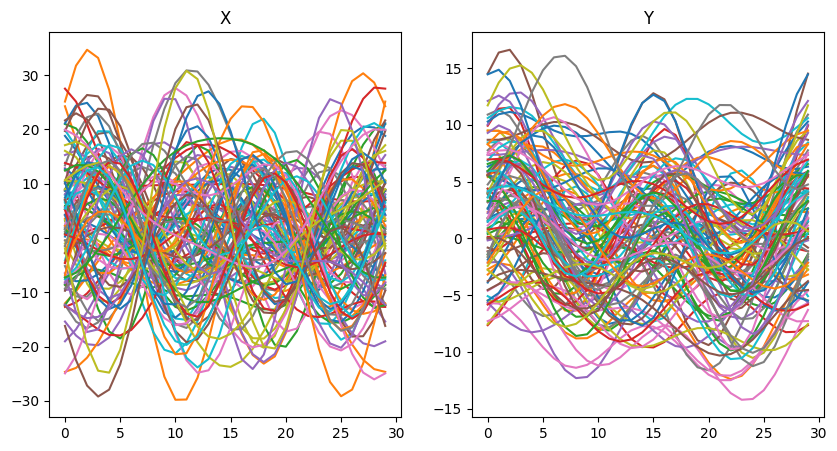

In [11]:
plot_idenpendent(sampling_x_n, sampling_y_n)

## Setting 1 (tDIME)

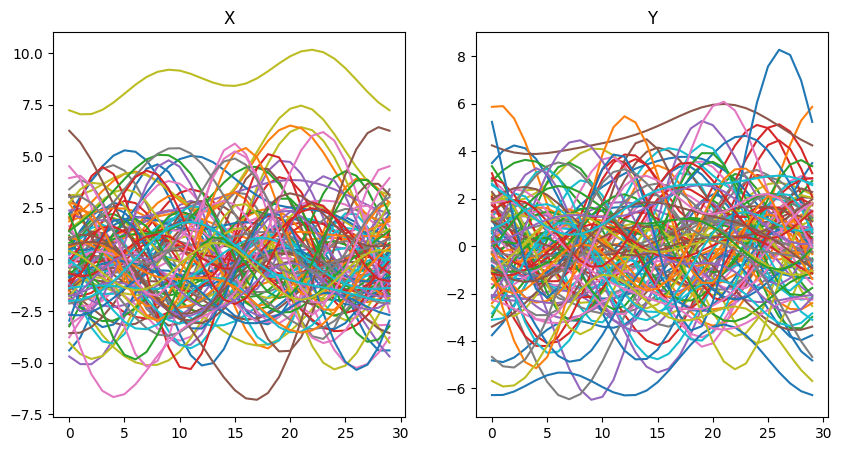

In [12]:
plot_idenpendent(sampling_x_t, sampling_y_t)

## Setting 2 (NDIME)

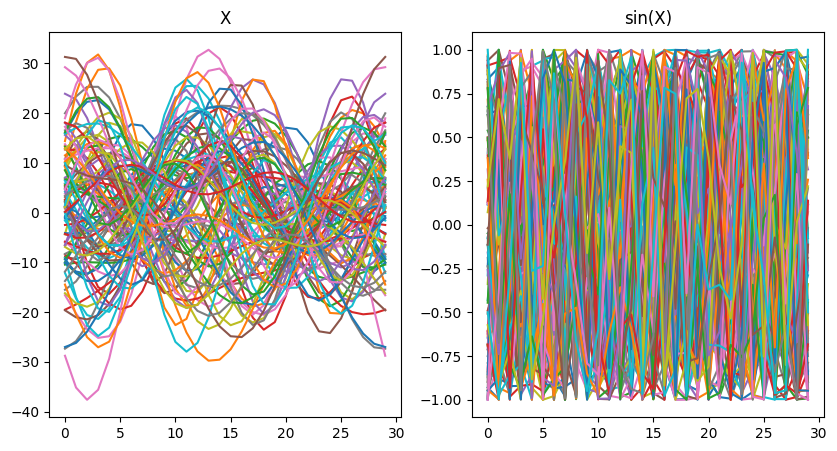

In [13]:
plot_dependent(sampling_x_n, np.sin, 'sin(X)')

## Setting 2 (tDIME)

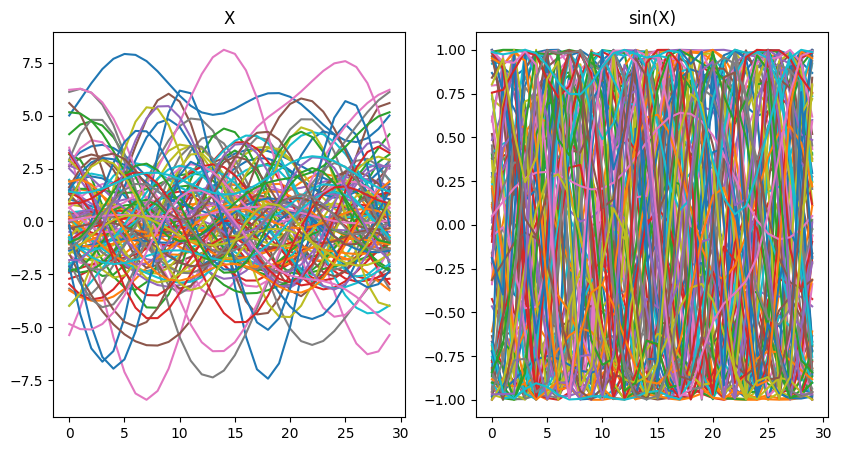

In [14]:
plot_dependent(sampling_x_t, np.sin, 'sin(X)')

## Setting 3 (NDIME)

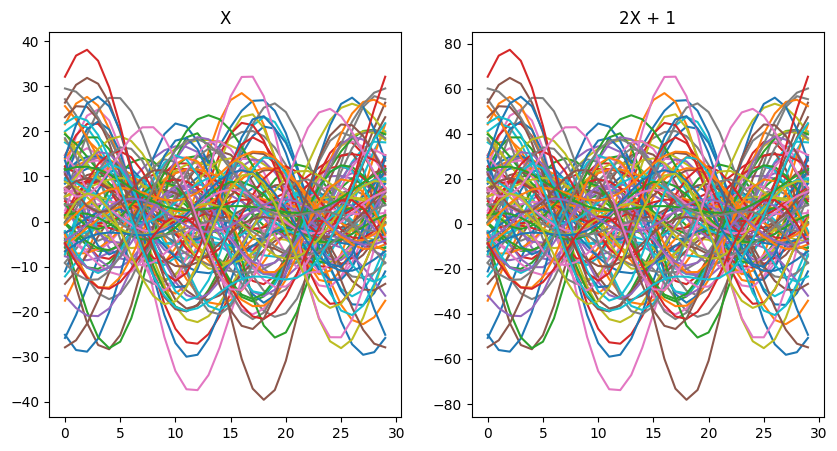

In [15]:
plot_dependent(sampling_x_n, lambda x: 2*x+1, '2X + 1')

## Setting 3 (tDIME)

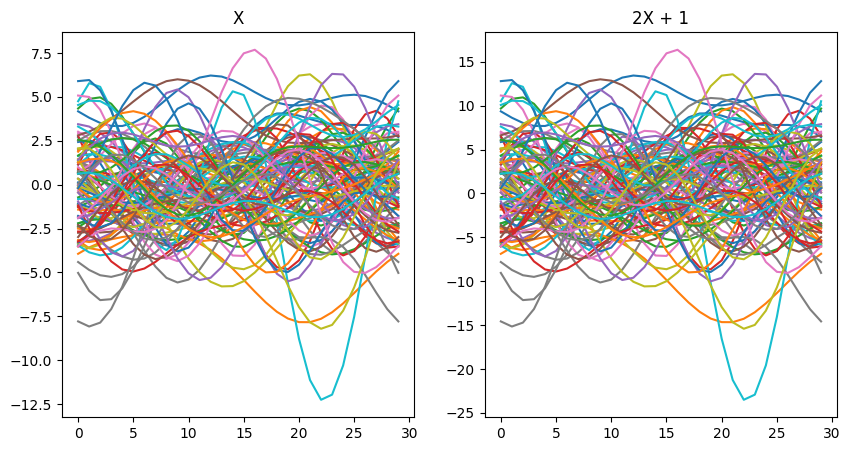

In [16]:
plot_dependent(sampling_x_t, lambda x: 2*x+1, '2X + 1')

## Setting 4 (NDIME)

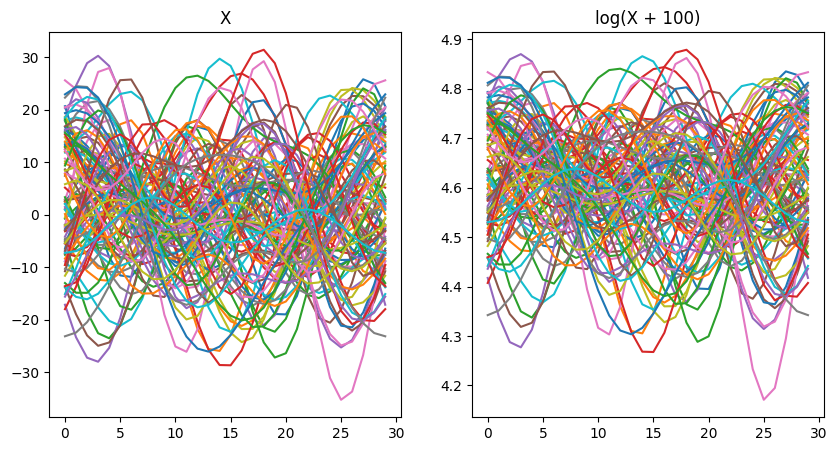

In [17]:
plot_dependent(sampling_x_n, lambda x: np.log(x + 100), 'log(X + 100)')

## Setting 4 (tDIME)

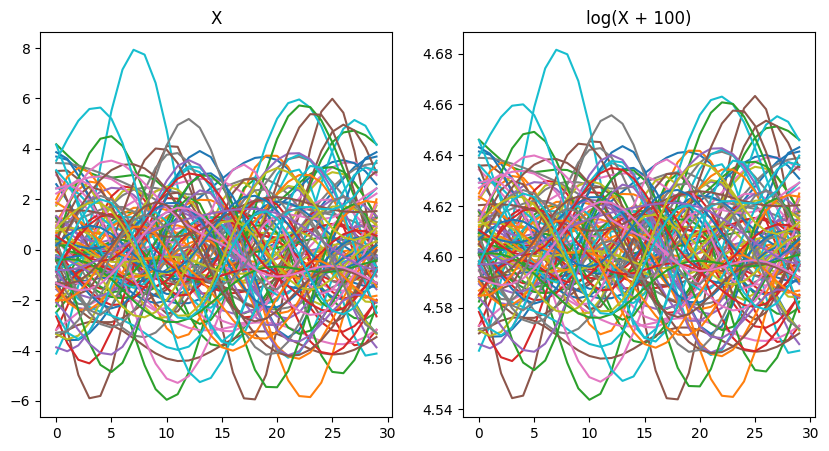

In [18]:
plot_dependent(sampling_x_t, lambda x: np.log(x + 100), 'log(X + 100)')

## Setting 5 (NDIME)

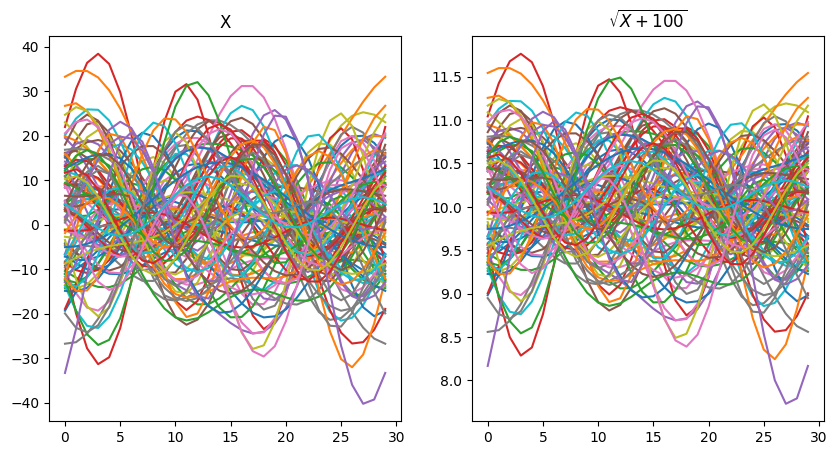

In [19]:
plot_dependent(sampling_x_n, lambda x: np.sqrt(x + 100), '$\sqrt{X + 100}$')

## Setting 5 (tDIME)

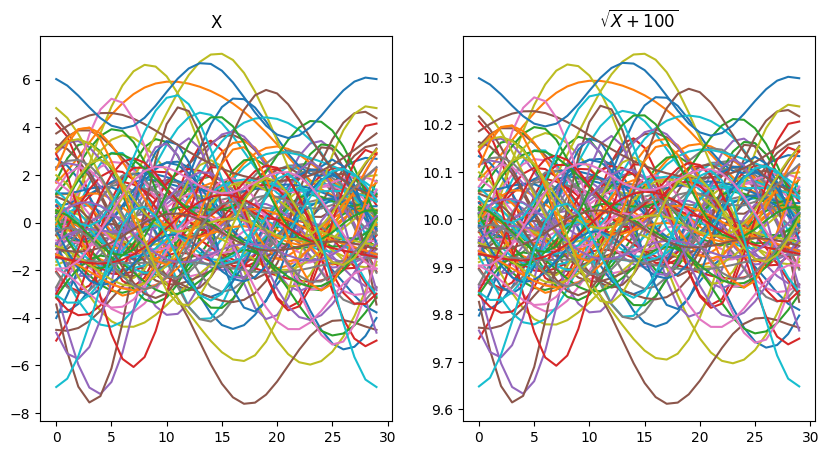

In [20]:
plot_dependent(sampling_x_t, lambda x: np.sqrt(x + 100), '$\sqrt{X + 100}$')

## Setting 6 (NDIME)

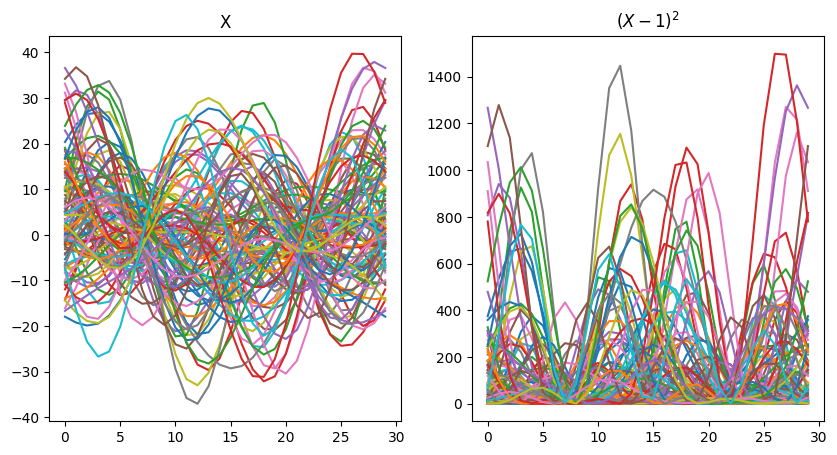

In [21]:
plot_dependent(sampling_x_n, lambda x: (x - 1)**2, '$(X - 1)^2$')

## Setting 6 (tDIME)

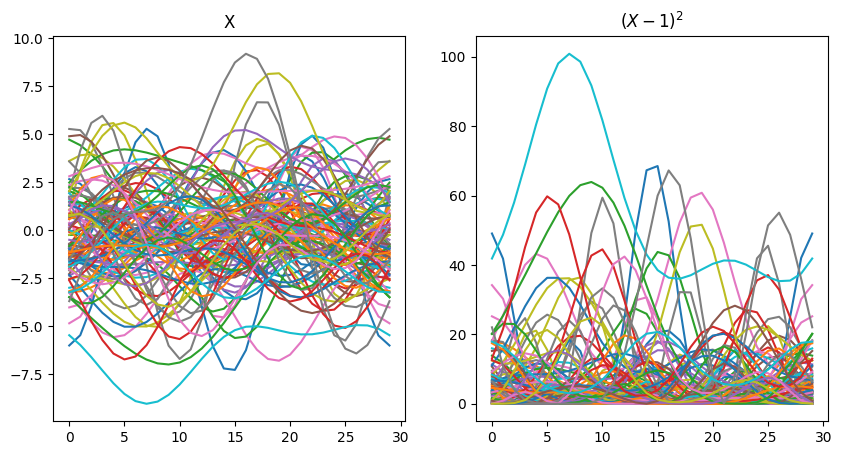

In [22]:
plot_dependent(sampling_x_t, lambda x: (x - 1)**2, '$(X - 1)^2$')

# Simulations (NDIME)

In [826]:
start_time = time.time()
results_n_1 = pd.DataFrame([setting_independent_n(sampling_x_n,
                                                  sampling_y_n,
                                                  C_dim_n = 1,
                                                  C_dim_t = 1e-119,
                                                  C_dim_t2 = 1e-28) \
                            for i in tqdm(range(100))])
end_time = time.time()
print("Time Duration", round((end_time - start_time) / 60, 2), "minutes")

! say Symulacje zakończone

  0%|          | 0/100 [00:00<?, ?it/s]

Time Duration 7.03 minutes


In [40]:
results_n_1.to_csv('independent.csv', index=False)

In [827]:
print("Independent data:")
results_n_1.map(lambda x: x.numpy()).astype(float).apply(np.mean, axis = 0)

Independent data:


vec_n    0.08
vec_t    0.01
fda_n    0.06
fda_t    0.05
dtype: float64

In [828]:
start_time = time.time()
results_n_2 = pd.DataFrame([setting_dependent_n(lambda x: np.sin(x), 
                                                sampling_x_n,
                                                C_dim_n = 1,
                                                C_dim_t = 1e-95,
                                                C_dim_t2 = 1e-17) \
                            for i in tqdm(range(100))])
end_time = time.time()
print("Time Duration", round((end_time - start_time) / 60, 2), "minutes")

! say Symulacje zakończone

  0%|          | 0/100 [00:00<?, ?it/s]

Time Duration 7.06 minutes


In [39]:
results_n_2.to_csv("sinus.csv", index=False)

In [829]:
print("Sinus data:")
results_n_2.map(lambda x: x.numpy()).astype(float).apply(np.mean, axis = 0)

Sinus data:


vec_n    0.04
vec_t    0.07
fda_n    0.03
fda_t    0.00
dtype: float64

In [830]:
start_time = time.time()
results_n_3 = pd.DataFrame([setting_dependent_n(lambda x: 2*x + 1,
                                                sampling_x_n,
                                                C_dim_n = 1,
                                                C_dim_t = 1e-139,
                                                C_dim_t2 = 1e-40) \
                            for i in tqdm(range(100))])
end_time = time.time()
print("Time Duration", round((end_time - start_time) / 60, 2), "minutes")

! say Symulacje zakończone

  0%|          | 0/100 [00:00<?, ?it/s]

Time Duration 7.04 minutes


In [38]:
results_n_3.to_csv('affinic.csv', index=False)

In [831]:
print("Affinic data:")
results_n_3.map(lambda x: x.numpy()).astype(float).apply(np.mean, axis = 0)

Affinic data:


vec_n    1.0
vec_t    1.0
fda_n    1.0
fda_t    1.0
dtype: float64

In [832]:
start_time = time.time()
results_n_4 = pd.DataFrame([setting_dependent_n(lambda x: np.log(x + 100), 
                                                sampling_x_n,
                                                C_dim_n = 1,
                                                C_dim_t = 1e-97,
                                                C_dim_t2 = 1e-21) \
                            for i in tqdm(range(100))])
end_time = time.time()
print("Time Duration", round((end_time - start_time) / 60, 2), "minutes")

! say Symulacje zakończone

  0%|          | 0/100 [00:00<?, ?it/s]

Time Duration 7.22 minutes


In [37]:
results_n_4.to_csv('logarithm.csv', index=False)

In [833]:
print("Logarithm data:")
results_n_4.map(lambda x: x.numpy()).astype(float).apply(np.mean, axis = 0)

Logarithm data:


vec_n    0.21
vec_t    1.00
fda_n    0.72
fda_t    1.00
dtype: float64

In [834]:
start_time = time.time()
results_n_5 = pd.DataFrame([setting_dependent_n(lambda x: np.sqrt(x + 100),
                                                sampling_x_n,
                                                C_dim_n = 1,
                                                C_dim_t = 1e-107,
                                                C_dim_t2 = 1e-20) \
                            for i in tqdm(range(100))])
end_time = time.time()
print("Time Duration", round((end_time - start_time) / 60, 2), "minutes")

! say Symulacje zakończone

  0%|          | 0/100 [00:00<?, ?it/s]

Time Duration 7.1 minutes


In [36]:
results_n_5.to_csv('square_root.csv', index=False)

In [835]:
print("Square root data:")
results_n_5.map(lambda x: x.numpy()).astype(float).apply(np.mean, axis = 0)

Square root data:


vec_n    0.17
vec_t    1.00
fda_n    0.11
fda_t    1.00
dtype: float64

In [864]:
start_time = time.time()
results_n_6 = pd.DataFrame([setting_dependent_n(lambda x: (x - 1)**2, 
                                                sampling_x_n,
                                                C_dim_n = 1,
                                                C_dim_t = 1e-166,
                                                C_dim_t2 = 1e-49) \
                            for i in tqdm(range(100))])
end_time = time.time()
print("Time Duration", round((end_time - start_time) / 60, 2), "minutes")

! say Symulacje zakończone

  0%|          | 0/100 [00:00<?, ?it/s]

Time Duration 7.06 minutes


In [35]:
results_n_6.to_csv('squared.csv', index=False)

In [865]:
print("Squared data:")
results_n_6.map(lambda x: x.numpy()).astype(float).apply(np.mean, axis = 0)

Squared data:


vec_n    1.0
vec_t    1.0
fda_n    1.0
fda_t    1.0
dtype: float64

# Simulations (tDIME)

In [866]:
start_time = time.time()
results_t_1 = pd.DataFrame([setting_independent_n(sampling_x_t, 
                                                  sampling_y_t,
                                                  C_dim_n = 1,
                                                  C_dim_t = 1e-87,
                                                  C_dim_t2 = 1e-16) \
                            for i in tqdm(range(100))])
end_time = time.time()
print("Time Duration", round((end_time - start_time) / 60, 2), "minutes")

! say Symulacje zakończone

  0%|          | 0/100 [00:00<?, ?it/s]

Time Duration 7.23 minutes


In [23]:
results_t_1.to_csv('independent_t.csv', index=False)

In [867]:
print("Independent data:")
results_t_1.map(lambda x: x.numpy()).astype(float).apply(np.mean, axis = 0)

Independent data:


vec_n    0.02
vec_t    0.04
fda_n    0.03
fda_t    0.04
dtype: float64

In [868]:
start_time = time.time()
results_t_2 = pd.DataFrame([setting_dependent_n(lambda x: np.sin(x), 
                                                sampling_x_t,
                                                  C_dim_n = 1,
                                                  C_dim_t = 1e-74,
                                                  C_dim_t2 = 1e-14) \
                            for i in tqdm(range(100))])
end_time = time.time()
print("Time Duration", round((end_time - start_time) / 60, 2), "minutes")

! say Symulacje zakończone

  0%|          | 0/100 [00:00<?, ?it/s]

Time Duration 7.32 minutes


In [26]:
results_t_2.to_csv("sinus_t.csv", index=False)

In [869]:
print("Sinus data:")
results_t_2.map(lambda x: x.numpy()).astype(float).apply(np.mean, axis = 0)

Sinus data:


vec_n    0.07
vec_t    0.20
fda_n    1.00
fda_t    0.85
dtype: float64

In [870]:
start_time = time.time()
results_t_3 = pd.DataFrame([setting_dependent_n(lambda x: 2*x + 1, 
                                                sampling_x_t,
                                                  C_dim_n = 1,
                                                  C_dim_t = 1e-99,
                                                  C_dim_t2 = 1e-24) \
                            for i in tqdm(range(100))])
end_time = time.time()
print("Time Duration", round((end_time - start_time) / 60, 2), "minutes")

! say Symulacje zakończone

  0%|          | 0/100 [00:00<?, ?it/s]

Time Duration 7.44 minutes


In [29]:
results_t_3.to_csv('affinic_t.csv', index=False)

In [871]:
print("Affinic data:")
results_t_3.map(lambda x: x.numpy()).astype(float).apply(np.mean, axis = 0)

Affinic data:


vec_n    1.0
vec_t    1.0
fda_n    1.0
fda_t    1.0
dtype: float64

In [872]:
start_time = time.time()
results_t_4 = pd.DataFrame([setting_dependent_n(lambda x: np.log(x + 100), 
                                                sampling_x_t,
                                                  C_dim_n = 1,
                                                  C_dim_t = 1e-75,
                                                  C_dim_t2 = 1e-13) \
                            for i in tqdm(range(100))])
end_time = time.time()
print("Time Duration", round((end_time - start_time) / 60, 2), "minutes")

! say Symulacje zakończone

  0%|          | 0/100 [00:00<?, ?it/s]

Time Duration 7.52 minutes


In [32]:
results_t_4.to_csv('logarithm_t.csv', index=False)

In [873]:
print("Logarithm data:")
results_t_4.map(lambda x: x.numpy()).astype(float).apply(np.mean, axis = 0)

Logarithm data:


vec_n    0.87
vec_t    1.00
fda_n    1.00
fda_t    1.00
dtype: float64

In [874]:
start_time = time.time()
results_t_5 = pd.DataFrame([setting_dependent_n(lambda x: np.sqrt(x + 100), 
                                                sampling_x_t,
                                                  C_dim_n = 1,
                                                  C_dim_t = 1e-86,
                                                  C_dim_t2 = 1e-13) \
                            for i in tqdm(range(100))])
end_time = time.time()
print("Time Duration", round((end_time - start_time) / 60, 2), "minutes")

! say Symulacje zakończone

  0%|          | 0/100 [00:00<?, ?it/s]

Time Duration 7.41 minutes


In [35]:
results_t_5.to_csv('square_root_t.csv', index=False)

In [875]:
print("Square root data:")
results_t_5.map(lambda x: x.numpy()).astype(float).apply(np.mean, axis = 0)

Square root data:


vec_n    1.00
vec_t    0.98
fda_n    0.95
fda_t    1.00
dtype: float64

In [876]:
start_time = time.time()
results_t_6 = pd.DataFrame([setting_dependent_n(lambda x: (x - 1)**2,
                                                sampling_x_t,
                                                  C_dim_n = 1,
                                                  C_dim_t = 1e-102,
                                                  C_dim_t2 = 1e-25) \
                            for i in tqdm(range(100))])
end_time = time.time()
print("Time Duration", round((end_time - start_time) / 60, 2), "minutes")

! say Symulacje zakończone

  0%|          | 0/100 [00:00<?, ?it/s]

Time Duration 7.34 minutes


In [38]:
results_t_6.to_csv('squared.csv', index=False)

In [877]:
print("Squared data:")
results_t_6.map(lambda x: x.numpy()).astype(float).apply(np.mean, axis = 0)

Squared data:


vec_n    1.0
vec_t    1.0
fda_n    1.0
fda_t    1.0
dtype: float64

# Sanity check

In [140]:
def sanity_check_independent(func, coef = True, sampling = 't'):
    list = torch.tensor([])
    for i in range(100):
        if sampling == 't':
            X, coef_X = sample_X(n, sampling_x_t)
            Y, coef_Y = sample_Y(n, sampling_y_t)
        elif sampling == 'n':
            X, coef_X = sample_X(n, sampling_x_t)
            Y, coef_Y = sample_Y(n, sampling_y_t)
        else: return(print('Invalid sampling method!'))
    
        if coef:
            list = torch.cat((list, torch.tensor([func(coef_X, coef_Y, HH, C_dim = 1)])),dim=0)
        else:
            list = torch.cat((list, torch.tensor([func(X, Y, HH, C_dim = 1)])),dim=0)
        
    v1 = np.round(np.min(np.log10(list.numpy())))
    v2 = np.round(np.mean(np.log10(list.numpy())))
    v3 = np.round(np.max(np.log10(list.numpy())))
    v4 = np.round(100 * np.mean(list.numpy() < 0))
    v5 = np.max(list.numpy()) - np.min(list.numpy())
    v5 = np.round(np.log10(v5))
    
    return pd.DataFrame({'stat': ['min','mean','max','%_negative', 'log10_of_spread'],
             'value': [v1,v2,v3,v4,v5]})

def sanity_check_dependent(func, func2, coef = True, sampling = 't', C_dim = 1):
    list = torch.tensor([])
    for i in range(100):
        if sampling == 't':
            X, coef_X = sample_X(n, sampling_x_t)
        elif sampling == 'n':
            X, coef_X = sample_X(n, sampling_x_n)
        else: return(print('Invalid sampling method!'))
    
        Y = func2(X)
        coef_Y = coef_Y_return(Y)
        if coef:
            list = torch.cat((list, torch.tensor([func(coef_X, coef_Y, HH, C_dim = C_dim)])),dim=0)
        else:
            list = torch.cat((list, torch.tensor([func(X, Y, HH, C_dim = C_dim)])),dim=0)
        
    v1 = np.round(np.min(np.log10(list.numpy())))
    v2 = np.round(np.mean(np.log10(list.numpy())))
    v3 = np.round(np.max(np.log10(list.numpy())))
    v4 = np.round(100 * np.mean(list.numpy() < 0))
    v5 = np.max(list.numpy()) - np.min(list.numpy())
    v5 = np.round(np.log10(v5))
    
    return pd.DataFrame({'stat': ['min','mean','max','%_negative', 'log10_of_spread'],
             'value': [v1,v2,v3,v4,v5]})

In [113]:
for i in ['tDIME', 'NDIME']:
    for j in [True, False]:
        for k in ['t', 'n']:
            if i == 'tDIME':
                print(i + '\n', 'coef: ' + str(j) + '\n', 'sampling: ' + k + '\n')
                print(sanity_check_independent(tDIME, coef = j, sampling = k))
                print('\n')
            else:
                print(i + '\n', 'coef: ' + str(j) + '\n', 'sampling: ' + k + '\n')
                print(sanity_check_independent(NDIME, coef = j, sampling = k))
                print('\n')

tDIME
 coef: True
 sampling: t

              stat  value
0              min   32.0
1             mean   34.0
2              max   36.0
3       %_negative    0.0
4  log10_of_spread   36.0


tDIME
 coef: True
 sampling: n

              stat  value
0              min   33.0
1             mean   34.0
2              max   36.0
3       %_negative    0.0
4  log10_of_spread   36.0


tDIME
 coef: False
 sampling: t

              stat  value
0              min  172.0
1             mean  177.0
2              max  184.0
3       %_negative    0.0
4  log10_of_spread  184.0


tDIME
 coef: False
 sampling: n

              stat  value
0              min  173.0
1             mean  177.0
2              max  185.0
3       %_negative    0.0
4  log10_of_spread  185.0


NDIME
 coef: True
 sampling: t

              stat  value
0              min   -5.0
1             mean   -5.0
2              max   -4.0
3       %_negative    0.0
4  log10_of_spread   -4.0


NDIME
 coef: True
 sampling: n

              st

In [141]:
functions = {'squared': lambda x: (x - 1)**2,
             'square root': lambda x: np.sqrt(x + 100),
             'logarithm': lambda x: np.log(x + 100),
             'affinic': lambda x: 2*x + 1,
             'sinus': lambda x: np.sin(x)}

C_dim_values = {'squared': 1e-102,
             'square root': 1e-86,
             'logarithm': 1e-75,
             'affinic': 1e-99,
             'sinus': 1e-74}

In [143]:
for i in ['tDIME', 'NDIME']:
    for j in [True, False]:
        for k in ['t', 'n']:
            for l in functions.keys():
                if i == 'tDIME':
                    print(i + '\n', 'coef: ' + str(j) + '\n', 'sampling: ' + k + '\n', l + '\n')
                    print(sanity_check_dependent(tDIME, 
                                                 func2 = functions['squared'], 
                                                 coef = j, 
                                                 sampling = k, 
                                                 C_dim = C_dim_values[l]))
                    print('\n')
                else:
                    print(i + '\n', 'coef: ' + str(j) + '\n', 'sampling: ' + k + '\n', l + '\n')
                    print(sanity_check_dependent(NDIME, 
                                                 func2 = functions['squared'], 
                                                 coef = j, 
                                                 sampling = k))
                    print('\n')

tDIME
 coef: True
 sampling: t
 squared

              stat  value
0              min -153.0
1             mean -148.0
2              max -140.0
3       %_negative    0.0
4  log10_of_spread -140.0


tDIME
 coef: True
 sampling: t
 square root

              stat  value
0              min -120.0
1             mean -117.0
2              max -112.0
3       %_negative    0.0
4  log10_of_spread -112.0


tDIME
 coef: True
 sampling: t
 logarithm

              stat  value
0              min  -98.0
1             mean  -94.0
2              max  -88.0
3       %_negative    0.0
4  log10_of_spread  -88.0


tDIME
 coef: True
 sampling: t
 affinic

              stat  value
0              min -146.0
1             mean -142.0
2              max -135.0
3       %_negative    0.0
4  log10_of_spread -135.0


tDIME
 coef: True
 sampling: t
 sinus

              stat  value
0              min  -96.0
1             mean  -92.0
2              max  -87.0
3       %_negative    0.0
4  log10_of_spread  -87.0


t

In [122]:
def sanity_check_dependent2(func, func2, coef = True, sampling = 't', C_dim = 1):
    list = torch.tensor([])
    for i in range(100):
        if sampling == 't':
            X, coef_X = sample_X(n, sampling_x_t)
        elif sampling == 'n':
            X, coef_X = sample_X(n, sampling_x_n)
        else: return(print('Invalid sampling method!'))
    
        Y = func2(X)
        coef_Y = coef_Y_return(Y)
        if coef:
            list = torch.cat((list, torch.tensor([func(coef_X, coef_Y, HH, C_dim = C_dim)])),dim=0)
        else:
            list = torch.cat((list, torch.tensor([func(X, Y, HH, C_dim = C_dim)])),dim=0)
    
    return list

In [138]:
sanity_check_dependent2(tDIME, 
                        functions['square root'], 
                        coef = False, 
                        sampling = 'n', 
                        C_dim = 1)

tensor([4.6120e+217, 1.1732e+219, 7.0202e+217, 2.3596e+217, 6.7415e+218,
        2.4612e+219, 1.0757e+217, 4.8836e+217, 4.2487e+216, 3.7761e+216,
        1.1788e+218, 1.3611e+217, 2.5737e+218, 2.7019e+216, 9.2433e+217,
        2.5347e+217, 3.7590e+217, 3.5016e+217, 3.0286e+217, 5.4696e+219,
        9.9068e+218, 2.1776e+218, 2.3403e+219, 3.3218e+216, 1.5601e+217,
        1.1661e+216, 3.2668e+219, 1.2491e+218, 1.0769e+220, 5.2557e+216,
        1.9040e+219, 8.7765e+215, 2.5699e+218, 2.4077e+217, 5.6677e+216,
        3.5707e+219, 7.9147e+215, 7.5356e+217, 8.9021e+216, 5.0747e+217,
        1.3615e+218, 9.4817e+217, 2.3898e+217, 8.0584e+217, 3.9961e+218,
        2.2855e+217, 2.6570e+216, 5.7016e+217, 7.7784e+218, 8.1237e+217,
        2.4518e+217, 5.0731e+216, 1.3961e+219, 9.0997e+216, 4.2530e+219,
        3.7578e+219, 5.3989e+216, 1.2849e+219, 1.2184e+216, 1.1524e+219,
        1.9933e+219, 2.2688e+218, 1.7349e+216, 2.6705e+218, 6.9430e+218,
        1.2647e+220, 8.3046e+216, 1.5506e+217, 5.61